# Training Resnet50 for classification of Emergency and Non-emergency Vehicle


In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Updated directory structure
image_dir = "../Dataset/Vehicles/train"

class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, img_size, augmentation=None):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation = augmentation
        self.indices = np.arange(len(file_paths))

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        batch_paths = [self.file_paths[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]
        images, labels = self.__load_data(batch_paths, batch_labels)
        return images, labels

    def __load_data(self, batch_paths, batch_labels):
        images = []
        for image_path in batch_paths:
            img = load_img(image_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0
            if self.augmentation:
                img = self.augmentation(image=img)['image']
            images.append(img)
        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Function to extract image paths and labels
def create_image_path_labels(image_dir):
    image_paths = []
    image_labels = []
    
    for label in ["0", "1"]:  # 0: Non-emergency, 1: Emergency
        class_dir = os.path.join(image_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            image_labels.append(int(label))  # Convert label to integer
    
    return image_paths, image_labels

In [15]:
# Get image paths and labels
img_paths, img_labels = create_image_path_labels(image_dir)

# Hyperparameters
batch_size = 20
img_size = (224, 224)
num_classes = 2  # Binary classification (emergency vs non-emergency)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=100, decay_rate=0.96, staircase=True
)

epochs = 30

# Convert Labels to One-Hot Encoding
img_labels = to_categorical(img_labels, num_classes=num_classes)

# Initialize Data Generator
data_generator = CustomDataGenerator(img_paths, img_labels, batch_size, img_size, augmentation=None)

# Load Pretrained ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)  # Fully connected layer
output_layer = Dense(num_classes, activation="softmax")(x)  # Ensure final output layer is explicitly built

# Create Model with proper output
model = Model(inputs=base_model.input, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the Model
model.compile(
    optimizer=optimizer, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )


# Train the Model
history = model.fit(
    data_generator,
    epochs=epochs,
    steps_per_epoch=len(data_generator),
    verbose=1,
)

# Save the Model
model.save("2resnet50_custom_data_generator.h5")

# Evaluate the Model
loss, accuracy = model.evaluate(data_generator)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.5655 - loss: 0.6896
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 345s 1s/step - accuracy: 0.7138 - loss: 0.5734
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 335s 1s/step - accuracy: 0.7331 - loss: 0.5424
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.7427 - loss: 0.5264
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7315 - loss: 0.5357
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.7597 - loss: 0.4940
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.7449 - loss: 0.5076
Epoch 8/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.7723 - loss: 0.4728
Epoch 9/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7762 - loss: 0.4678
Epoch 10/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7786 - loss: 0.4658
Epoch 11/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.7864 - loss: 0.4521
Epoch 12/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 

231/231 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.8285 - loss: 0.3872
Loss: 0.3837, Accuracy: 0.8312


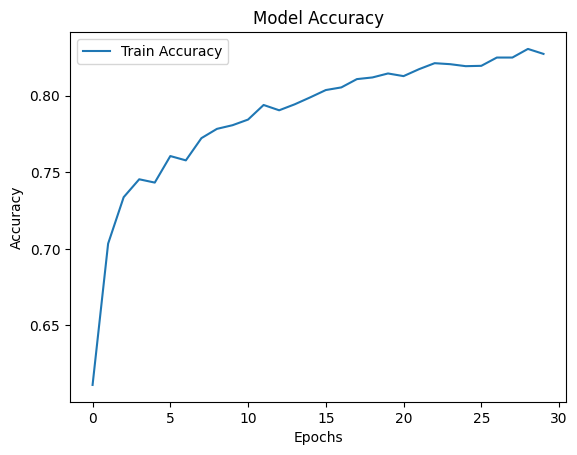

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

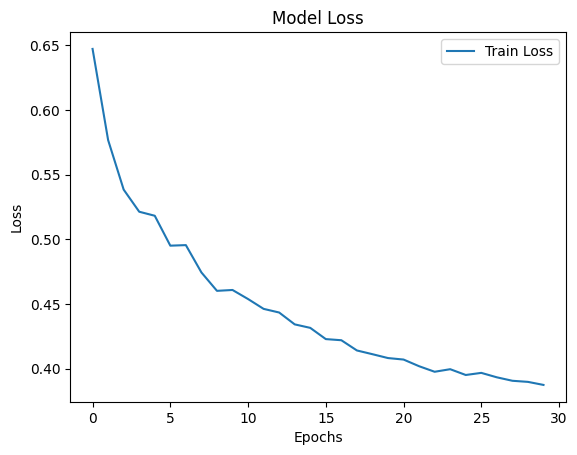

In [18]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Testing

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence

# Define test dataset directory
test_image_dir = "../Dataset/Vehicles/validation"  # Change if needed

# Function to extract image paths and labels for test dataset
def create_image_path_labels(image_dir):
    image_paths = []
    image_labels = []
    
    for label in ["0", "1"]:  # 0: Non-emergency, 1: Emergency
        class_dir = os.path.join(image_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            image_labels.append(int(label))  # Convert label to integer
    
    return image_paths, image_labels

# Load test image paths and labels
test_img_paths, test_img_labels = create_image_path_labels(test_image_dir)

# Convert labels to one-hot encoding
num_classes = 2
test_img_labels = to_categorical(test_img_labels, num_classes=num_classes)

# Define Data Generator for Testing
class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, img_size):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.indices = np.arange(len(file_paths))

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        batch_paths = [self.file_paths[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]
        images, labels = self.__load_data(batch_paths, batch_labels)
        return images, labels

    def __load_data(self, batch_paths, batch_labels):
        images = []
        for image_path in batch_paths:
            img = load_img(image_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
        return np.array(images), np.array(batch_labels)


In [20]:
# Set Parameters
batch_size = 30
img_size = (224, 224)

# Initialize Test Data Generator
test_data_generator = CustomDataGenerator(test_img_paths, test_img_labels, batch_size, img_size)

# Load the trained model
model = tf.keras.models.load_model("2resnet50_custom_data_generator.h5")

# Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_data_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7882 - loss: 0.4413
Test Loss: 0.4549, Test Accuracy: 0.7818


## Predicting

In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model = load_model('2resnet50_custom_data_generator.h5')

# Path to the input image
image_path = 'road_test2.jpg'

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
predictions = model.predict(img_array)

# Decode the predictions
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class = 'Emergency' if predicted_class_index == 1 else 'Non-Emergency'

print(f'Predicted Class: {predicted_class}')


/Users/naveenkrishna/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicted Class: Non-Emergency


In [1]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model = load_model('2resnet50_custom_data_generator.h5')

# Path to the input image
image_path = 'road_test.jpg'

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
predictions = model.predict(img_array)

# Decode the predictions
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class = 'Emergency' if predicted_class_index == 1 else 'Non-Emergency'

print(f'Predicted Class: {predicted_class}')


/Users/naveenkrishna/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicted Class: Emergency


In [42]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
model = load_model('2resnet50_custom_data_generator.h5')

# Path to the input image
image_path = 'vehicle_frame_14.jpg_0.jpg'

# Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalize the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
predictions = model.predict(img_array)

# Decode the predictions
predicted_class_index = np.argmax(predictions, axis=1)
predicted_class = 'Emergency' if predicted_class_index == 1 else 'Non-Emergency'

print(f'Predicted Class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Emergency
